# Low Light Enhancement using Deep Retinex Decomposition

Images have a wide range of applications in the field of engineering like in medical field, remote sensing, transmission and encoding, machine vision, robotics, pattern recognition, etc.

In some cases, the images captured by cameras contains blur, noise and low lightness in it. This causes difficulty to viewer in extracting the information from it.There can be many causes of this problem like low light environment, poor performance of the equipment, inappropriate configurations of the equipment.

The objective of this case study is to build a model(Deep Retinex Decomposition model) using deep learning techniques like CNN, Encoder-decoder that will learn from the existing dataset of low and high quality images and will be able to convert any poor quality image given to it into the high quality image.


In [ ]:
!pip install tensorflow==1.15.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
import random
from PIL import Image
from glob import glob
from tqdm import tqdm
import pickle

# Exploratory data analysis

##### https:/ /github.com/weichen582/RetinexNet
The dataset named LOL (LOw Light paired) dataset used for the problem is taken from the above link. It contains 5000 low/normal light images pairs of different kinds such as household appliances, toys, books, garden, food items, playground, clubs, streets etc.

These raw images are resized to 128*128 and converted to
Portable Network Graphics format.

Below figure shows the subset of these images.


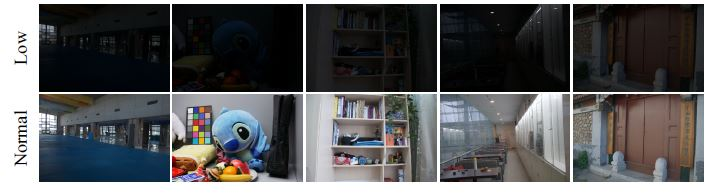

In [2]:
def load_images(file):
    im = Image.open(file)
    newsize = (128, 128)
    im = im.resize(newsize)
    return np.array(im, dtype="float32") / 255.0

## Training data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

In [3]:
data = "/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Fall 2023-24/EECS 6154 - DIP Theory and Algorithms/Project"

In [9]:
train_low_data_names = glob(os.path.join(data, 'LOL dataset', 'our485', 'low/*.png'))
train_low_data_names.sort()
train_high_data_names = glob(os.path.join(data, 'LOL dataset', 'our485', 'high/*.png'))
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)

train_low_data = []
train_high_data = []

for idx in tqdm(range(485)):
#for idx in tqdm(range(len(train_low_data_names))):
    low_im = load_images(train_low_data_names[idx])
    train_low_data.append(low_im)
    high_im = load_images(train_high_data_names[idx])
    train_high_data.append(high_im)

100%|██████████| 485/485 [00:17<00:00, 27.29it/s]


In [ ]:
print('Number of training data points: %d' % len(train_low_data))

Number of training data points: 5000


## Testing data

In [ ]:
eval_low_data = []

eval_low_data_name = glob('/content/drive/MyDrive/Case_study_2/data/eval15/low/*.png')

for idx in tqdm(range(len(eval_low_data_name))):
    eval_low_im = load_images(eval_low_data_name[idx])
    eval_low_data.append(eval_low_im)

100%|██████████| 15/15 [00:00<00:00, 99.80it/s]


In [ ]:
eval_high_data = []

eval_high_data_name = glob('/content/drive/MyDrive/Case_study_2/data/eval15/high/*.png')

for idx in tqdm(range(len(eval_high_data_name))):
    eval_high_im = load_images(eval_high_data_name[idx])
    eval_high_data.append(eval_high_im)

100%|██████████| 15/15 [00:00<00:00, 95.30it/s]


In [ ]:
print('Number of testing data points: %d' % len(eval_low_data_name))

## Sample low light and high light image

In [ ]:
low_img = train_low_data[200]
print("Shape of the image", low_img.shape)

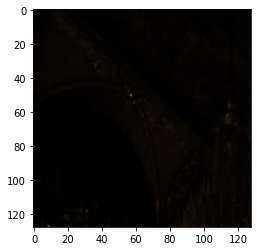

In [ ]:
plt.imshow(low_img[ : , : , :])

In [ ]:
high_img = train_high_data[200]
print("Shape of the image", high_img.shape)

Shape of the image (128, 128, 3)


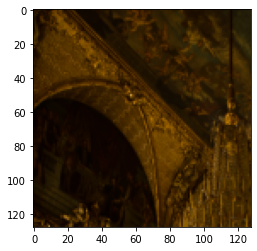

In [ ]:
plt.imshow(high_img[ : , : , :])

## Observations from EDA

Dataset for training contains 5000 images, each of one is an RGB image with size 128×128×3.

Dataset for testing contains 15 images, each of one is an RGB image with size 128×128×3.

For each image, we have a pair of low and high light image.

# Decomposition

In [ ]:
print(tf.__version__)

1.15.0


In [ ]:
def concat(layers):
    return tf.concat(layers, axis=3)

In [ ]:
def DecomNet(input_im, layer_num, channel=64, kernel_size=3):
    input_max = tf.reduce_max(input_im, axis=3, keepdims=True)
    input_im = concat([input_max, input_im])
    with tf.variable_scope('DecomNet', reuse=tf.AUTO_REUSE):
        conv = tf.layers.conv2d(input_im, channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        for idx in range(layer_num):
            conv = tf.layers.conv2d(conv, channel, kernel_size, padding='same', activation=tf.nn.relu, name='activated_layer_%d' % idx)
        conv = tf.layers.conv2d(conv, 4, kernel_size, padding='same', activation=None, name='recon_layer')

    R = tf.sigmoid(conv[:,:,:,0:3])
    L = tf.sigmoid(conv[:,:,:,3:4])

    return R, L

In [ ]:
def RelightNet(input_L, input_R, channel=64, kernel_size=3):
    input_im = concat([input_R, input_L])
    with tf.variable_scope('RelightNet', reuse=tf.AUTO_REUSE):
        conv0 = tf.layers.conv2d(input_im, channel, kernel_size, padding='same', activation=None)
        conv1 = tf.layers.conv2d(conv0, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv2, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)

        up1 = tf.image.resize_nearest_neighbor(conv3, (tf.shape(conv2)[1], tf.shape(conv2)[2]))
        deconv1 = tf.layers.conv2d(up1, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv2
        up2 = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(conv1)[1], tf.shape(conv1)[2]))
        deconv2= tf.layers.conv2d(up2, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv1
        up3 = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(conv0)[1], tf.shape(conv0)[2]))
        deconv3 = tf.layers.conv2d(up3, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv0

        deconv1_resize = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        deconv2_resize = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        feature_gather = concat([deconv1_resize, deconv2_resize, deconv3])
        feature_fusion = tf.layers.conv2d(feature_gather, channel, 1, padding='same', activation=None)
        output = tf.layers.conv2d(feature_fusion, 1, 3, padding='same', activation=None)
    return output

In [ ]:
def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

In [ ]:
class lowlight_enhance:

  def __init__(self, train_low_data, train_high_data, eval_low_data, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir):

    self.DecomNet_layer_num = 5
    self.sess = tf.Session()

    self.train_low_data = train_low_data
    self.train_high_data = train_high_data
    self.eval_low_data = eval_low_data
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.epoch = epoch
    self.learning_rate = learning_rate
    self.train_phase = train_phase

    self.train_low_data_ph = tf.placeholder(tf.float32, [None, None, None, 3], name='train_low_data_ph')
    self.train_high_data_ph = tf.placeholder(tf.float32, [None, None, None, 3], name='train_high_data_ph')
    self.lr_ph = tf.placeholder(tf.float32, name='lr_ph')

    self.ckpt_dir = ckpt_dir

    [R_low, I_low] = DecomNet(self.train_low_data_ph, layer_num=self.DecomNet_layer_num)
    [R_high, I_high] = DecomNet(self.train_high_data_ph, layer_num=self.DecomNet_layer_num)

    I_low_3 = concat([I_low, I_low, I_low])
    I_high_3 = concat([I_high, I_high, I_high])

    self.output_R_low = R_low
    self.output_I_low = I_low_3

    # loss
    self.recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  self.train_low_data_ph))
    self.recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - self.train_high_data_ph))
    self.recon_loss_mutal_low = tf.reduce_mean(tf.abs(R_high * I_low_3 - self.train_low_data_ph))
    self.recon_loss_mutal_high = tf.reduce_mean(tf.abs(R_low * I_high_3 - self.train_high_data_ph))
    self.equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))

    self.Ismooth_loss_low = self.smooth(I_low, R_low)
    self.Ismooth_loss_high = self.smooth(I_high, R_high)

    self.loss_Decom = self.recon_loss_low + self.recon_loss_high + 0.001 * self.recon_loss_mutal_low + 0.001 * self.recon_loss_mutal_high + 0.1 * self.Ismooth_loss_low + 0.1 * self.Ismooth_loss_high + 0.01 * self.equal_R_loss

    self.lr_ph = tf.placeholder(tf.float32, name='learning_rate')
    optimizer = tf.train.AdamOptimizer(self.lr_ph, name='AdamOptimizer')

    self.var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]

    self.train_op_Decom = optimizer.minimize(self.loss_Decom, var_list = self.var_Decom)

    self.sess.run(tf.global_variables_initializer())

    self.saver_Decom = tf.train.Saver(var_list = self.var_Decom)

    print("[*] Initialize model successfully...")

  def gradient(self, input_tensor, direction):
    self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
    self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

    if direction == "x":
        kernel = self.smooth_kernel_x
    elif direction == "y":
        kernel = self.smooth_kernel_y
    return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))

  def ave_gradient(self, input_tensor, direction):
    return tf.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

  def smooth(self, input_I, input_R):
    input_R = tf.image.rgb_to_grayscale(input_R)
    return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

  def evaluate_test(self):

    print("Evaluating for test data")
    Reflectance = []
    Illuminance = []

    for idx in range(len(self.eval_low_data)):
      input_low_eval = np.expand_dims(self.eval_low_data[idx], axis=0)

      if train_phase == "Decom":
        result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.train_low_data_ph: input_low_eval})

      Reflectance.append(result_1)
      Illuminance.append(result_2)

    return Reflectance, Illuminance

  def evaluate_train(self):

    print("Evaluating for train data")
    Reflectance = []
    Illuminance = []

    for idx in tqdm(range(len(self.train_low_data))):
    #for idx in tqdm(range(start_id, end_id)):
      input_low_train = np.expand_dims(self.train_low_data[idx], axis=0)

      if train_phase == "Decom":
        result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.train_low_data_ph: input_low_train})

      Reflectance.append(result_1)
      Illuminance.append(result_2)

    return Reflectance, Illuminance

  def train(self):

    numBatch = 30

    # load pretrained model

    train_op = self.train_op_Decom
    train_loss = self.loss_Decom
    saver = self.saver_Decom

    iter_num = 0
    start_epoch = 0
    start_step = 0
    lr1 = self.learning_rate

    start_time = time.time()
    image_id = 0

    for epoch in range(start_epoch, self.epoch):

      for batch_id in range(start_step, numBatch):

        # generate data for a batch
        batch_input_low = np.zeros((self.batch_size, self.patch_size, self.patch_size, 3), dtype="float32")
        batch_input_high = np.zeros((self.batch_size, self.patch_size, self.patch_size, 3), dtype="float32")
        for patch_id in range(self.batch_size):

          h, w, _ = self.train_low_data[image_id].shape
          x = random.randint(0, h - self.patch_size)
          y = random.randint(0, w - self.patch_size)

          rand_mode = random.randint(0, 7)
          batch_input_low[patch_id, :, :, :] = data_augmentation(self.train_low_data[image_id][x : x+self.patch_size, y : y+self.patch_size, :], rand_mode)
          batch_input_high[patch_id, :, :, :] = data_augmentation(self.train_high_data[image_id][x : x+self.patch_size, y : y+self.patch_size, :], rand_mode)

          image_id = (image_id + 1) % len(self.train_low_data)
          if image_id == 0:
            tmp = list(zip(self.train_low_data, self.train_high_data))
            random.shuffle(list(tmp))
            train_low_data, train_high_data  = zip(*tmp)

        # train
        _, loss = self.sess.run([train_op, train_loss], feed_dict={self.train_low_data_ph: batch_input_low, \
                                                                    self.train_high_data_ph: batch_input_high, \
                                                                    self.lr_ph: lr1[epoch]})

        print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
              % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1

  def save_pretrained(self):
    self.save(self.saver_Decom, self.ckpt_dir, "RetinexNet-%s" % self.train_phase)

  def load_pretrained(self):
    load_model_status = self.load(self.saver_Decom, self.ckpt_dir)
    print("[*] Model restore success!")

  def save(self, saver, ckpt_dir, model_name):
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)
    print("[*] Saving model %s" % model_name)
    saver.save(self.sess, \
                os.path.join(ckpt_dir, model_name), \
               )

  def load(self, saver, ckpt_dir):
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    full_path = ckpt_dir + '/RetinexNet-Decom'

    saver.restore(self.sess, full_path)
    return True


In [ ]:
epoch = 100
#epoch = 10
learning_rate = 0.001 * np.ones([epoch])
learning_rate[20:] = learning_rate[0] / 10.0
batch_size = 16
patch_size = 48
train_phase = "Decom"
ckpt_dir = "/content/drive/MyDrive/Case_study_2"

In [ ]:
model = lowlight_enhance(train_low_data, train_high_data, eval_low_data, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir)

In [ ]:
model.save_pretrained()

[*] Saving model RetinexNet-Decom


In [ ]:
model.load_pretrained()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Case_study_2/RetinexNet-Decom
[*] Model restore success!


In [ ]:
Reflectance, Illuminance = model.evaluate_train()

Evaluating for train data


100%|██████████| 5000/5000 [00:14<00:00, 350.94it/s]


In [ ]:
Reflectance_test, Illuminance_test = model.evaluate_test()

Evaluating for test data


## Plotting Reflectance and Illuminantion of a sample image

In [ ]:
R_img = Reflectance[0]
I_img = Illuminance[0]

R_img = R_img[0,:,:,:]
I_img = I_img[0,:,:,:]

#print(img.shape)
print(R_img.shape)
print(I_img.shape)

(128, 128, 3)
(128, 128, 3)


Plotting Reflectance of an image

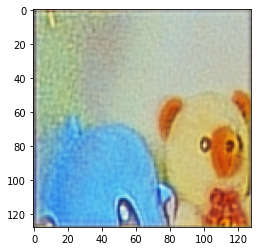

In [ ]:
plt.imshow(R_img[ : , : , :])

Plotting Illuminance of an image

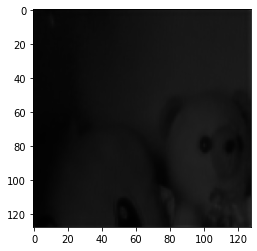

In [ ]:
plt.imshow(I_img[ : , : , :])

# Adjustment

In [ ]:
Reflectance_1 = list()
for i in tqdm(range(len(Reflectance))):
  R = Reflectance[i]
  R1 = R[0,:,:,:]
  Reflectance_1.append(R1)


100%|██████████| 5000/5000 [00:00<00:00, 528622.71it/s]


In [ ]:
Illuminance_1 = list()
for i in tqdm(range(len(Illuminance))):
  I = Illuminance[i]
  I1 = I[0,:,:,:]
  Illuminance_1.append(I1)

100%|██████████| 5000/5000 [00:00<00:00, 678843.75it/s]


In [ ]:
Reflectance_111 = np.array(Reflectance_1, dtype='float32')
Reflectance_111.shape

(5000, 128, 128, 3)

In [ ]:
Illuminance_111 = np.array(Illuminance_1, dtype='float32')
Illuminance_111.shape

(5000, 128, 128, 3)

In [ ]:
Reflectance_test_1 = list()
for i in tqdm(range(len(Reflectance_test))):
  R = Reflectance_test[i]
  R1 = R[0,:,:,:]
  Reflectance_test_1.append(R1)


100%|██████████| 15/15 [00:00<00:00, 46465.70it/s]


In [ ]:
Illuminance_test_1 = list()
for i in tqdm(range(len(Illuminance_test))):
  I = Illuminance_test[i]
  I1 = I[0,:,:,:]
  Illuminance_test_1.append(I1)

100%|██████████| 15/15 [00:00<00:00, 47197.72it/s]


In [ ]:
Reflectance_test_111 = np.array(Reflectance_test_1, dtype='float32')
Reflectance_test_111.shape

(15, 128, 128, 3)

In [ ]:
Illuminance_test_111 = np.array(Illuminance_test_1, dtype='float32')
Illuminance_test_111.shape

(15, 128, 128, 3)

In [ ]:
class lowlight_enhance_2:

  def __init__(self, train_high_data,  Reflectance, Illuminance, Reflectance_test, Illuminance_test, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir_2):

    self.sess = tf.Session()

    self.train_high_data = train_high_data

    self.R_low = Reflectance
    self.I_low = Illuminance

    self.R_low_test = Reflectance_test
    self.I_low_test = Illuminance_test

    self.batch_size = batch_size
    self.patch_size = patch_size
    self.epoch = epoch
    self.learning_rate = learning_rate
    self.train_phase = train_phase

    self.train_high_data_ph = tf.placeholder(tf.float32, [None, None, None, 3], name='train_high_data_ph')
    self.R_low_ph = tf.placeholder(tf.float32, [None, None, None, 3], name='R_low_ph')
    self.I_low_ph = tf.placeholder(tf.float32, [None, None, None, 3], name='I_low_ph')

    self.lr_ph = tf.placeholder(tf.float32, name='lr_ph')

    self.ckpt_dir_2 = ckpt_dir_2

    I_delta = RelightNet(self.I_low_ph, self.R_low_ph)

    I_delta_3 = concat([I_delta, I_delta, I_delta])

    self.output_I_delta = I_delta_3

    self.output_S = self.R_low_ph * I_delta_3

    self.relight_loss = tf.reduce_mean(tf.abs(self.R_low_ph * I_delta_3 - self.train_high_data_ph))

    self.Ismooth_loss_delta = self.smooth(I_delta, self.R_low_ph)

    self.loss_Relight = self.relight_loss + 3 * self.Ismooth_loss_delta

    self.lr_ph = tf.placeholder(tf.float32, name='learning_rate')
    optimizer = tf.train.AdamOptimizer(self.lr_ph, name='AdamOptimizer')

    self.var_Relight = [var for var in tf.trainable_variables() if 'RelightNet' in var.name]

    self.train_op_Relight = optimizer.minimize(self.loss_Relight, var_list = self.var_Relight)

    self.sess.run(tf.global_variables_initializer())

    self.saver_Relight = tf.train.Saver(var_list = self.var_Relight)

    print("[*] Initialize model successfully...")

  def gradient(self, input_tensor, direction):
    self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
    self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

    if direction == "x":
        kernel = self.smooth_kernel_x
    elif direction == "y":
        kernel = self.smooth_kernel_y
    return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))

  def ave_gradient(self, input_tensor, direction):
    return tf.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

  def smooth(self, input_I, input_R):
    input_R = tf.image.rgb_to_grayscale(input_R)
    return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

  def evaluate_test(self):

    print("Evaluating for test data")
    R_low_hat = []
    I_low_hat = []

    for idx in range(len(self.R_low_test)):
      input_R_low = np.expand_dims(self.R_low_test[idx], axis=0)
      input_I_low = np.expand_dims(self.I_low_test[idx], axis=0)

      if train_phase == "Relight":
        result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low,})

      R_low_hat.append(result_1)
      I_low_hat.append(result_2)

    return R_low_hat, I_low_hat

  def evaluate_train(self):

    print("Evaluating for train data")
    R_low_hat = []
    I_low_hat = []

    for idx in tqdm(range(len(self.R_low))):
    #for idx in tqdm(range(start_id, end_id)):
      input_R_low = np.expand_dims(self.R_low[idx], axis=0)
      input_I_low = np.expand_dims(self.I_low[idx], axis=0)

      if train_phase == "Relight":
        result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low,})

      R_low_hat.append(result_1)
      I_low_hat.append(result_2)

    return R_low_hat, I_low_hat

  def train(self):

    numBatch = 30

    train_op = self.train_op_Relight
    train_loss = self.loss_Relight
    saver = self.saver_Relight

    iter_num = 0
    start_epoch = 0
    start_step = 0
    lr1 = self.learning_rate

    start_time = time.time()
    image_id = 0

    for epoch in range(start_epoch, self.epoch):

      for batch_id in range(start_step, numBatch):

        # generate data for a batch
        batch_R_low = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")
        batch_I_low = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")
        batch_input_high = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")

        for patch_id in range(self.batch_size):

          batch_R_low[patch_id, :, :, :] = self.R_low[image_id, :, :, :]
          batch_I_low[patch_id, :, :, :] = self.I_low[image_id, :, :, :]
          batch_input_high[patch_id, :, :, :] = self.train_high_data[image_id][:,:,:]

          image_id = (image_id + 1) % len(self.R_low)
          if image_id == 0:
            tmp = list(zip(self.R_low, self.I_low))
            random.shuffle(list(tmp))
            R_low, I_low  = zip(*tmp)

        # train
        _, loss = self.sess.run([train_op, train_loss], feed_dict={self.R_low_ph: batch_R_low, \
                                                                    self.I_low_ph: batch_I_low, \
                                                                    self.lr_ph: lr1[epoch], \
                                                                    self.train_high_data_ph: batch_input_high})

        print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
              % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1

  def save_pretrained_2(self):
    self.save_2(self.saver_Relight, self.ckpt_dir_2, "RetinexNet-%s" % self.train_phase)

  def load_pretrained_2(self):
    load_model_status = self.load_2(self.saver_Relight, self.ckpt_dir_2)
    print("[*] Model restore success!")

  def save_2(self, saver, ckpt_dir, model_name):
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)
    print("[*] Saving model %s" % model_name)
    saver.save(self.sess, \
                os.path.join(ckpt_dir, model_name))

  def load_2(self, saver, ckpt_dir):
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    full_path = ckpt_dir + '/RetinexNet-Relight'

    saver.restore(self.sess, full_path)
    return True


In [ ]:
train_phase = "Relight"
ckpt_dir_2 = "/content/drive/MyDrive/Case_study_2"

In [ ]:
model2 = lowlight_enhance_2(train_high_data, Reflectance_111, Illuminance_111, Reflectance_test_111, Illuminance_test_111, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir_2)

[*] Initialize model successfully...


In [ ]:
model2.save_pretrained_2()

[*] Saving model RetinexNet-Relight


In [ ]:
model2.load_pretrained_2()

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Case_study_2/RetinexNet-Relight
[*] Model restore success!


In [ ]:
Output_S, Output_I_delta = model2.evaluate_train()

Evaluating for train data


100%|██████████| 5000/5000 [00:12<00:00, 398.14it/s]


In [ ]:
Output_S_test, Output_I_delta_test = model2.evaluate_test()

Evaluating for test data


## Plotting a sample low light and high light image (training data)

In [ ]:
hl_img = Output_S[0]
hl_img2 = Output_I_delta[0]

hl_img = hl_img[0,:,:,:]
hl_img2 = hl_img2[0,:,:,:]

#print(img.shape)
print(hl_img.shape)
print(hl_img2.shape)

(128, 128, 3)
(128, 128, 3)


Sample low light image

In [ ]:
low_img = train_low_data[0]
print("Shape of the image", low_img.shape)

Shape of the image (128, 128, 3)


Sample high light image

In [ ]:
high_img = train_high_data[0]
print("Shape of the image", high_img.shape)

Shape of the image (128, 128, 3)


Sample predicted high light image

In [ ]:
hl_image_final = hl_img*hl_img2

Text(0.5, 1.0, 'Predicted High light image')

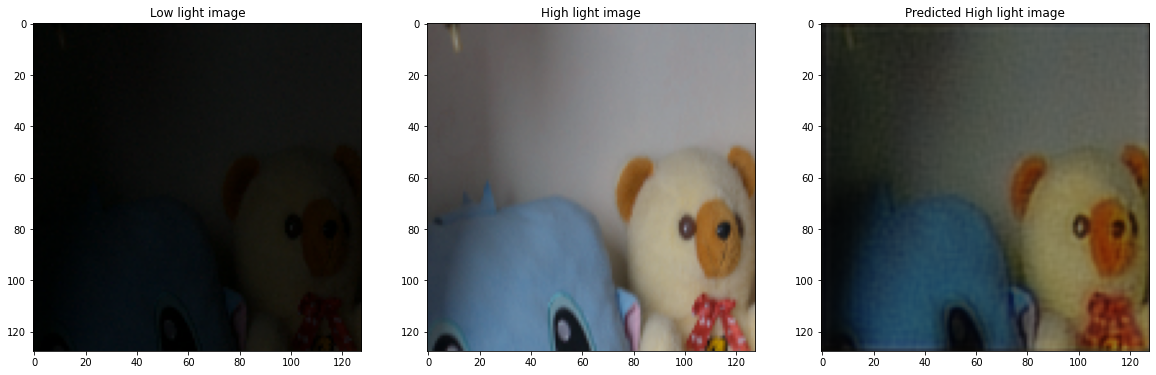

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
plt.imshow(low_img[ : , : , :])
plt.title('Low light image')

plt.subplot(1,3,2)
plt.imshow(high_img[ : , : , :])
plt.title('High light image')

plt.subplot(1,3,3)
plt.imshow(hl_image_final[ : , : , :])
plt.title('Predicted High light image')

## Plotting a sample low light and high light image (testing data)

In [ ]:
hl_img = Output_S_test[0]
hl_img2 = Output_I_delta_test[0]

hl_img = hl_img[0,:,:,:]
hl_img2 = hl_img2[0,:,:,:]

print(hl_img.shape)
print(hl_img2.shape)

(128, 128, 3)
(128, 128, 3)


Sample low light image

In [ ]:
low_img = eval_low_data[0]
print("Shape of the image", low_img.shape)

Shape of the image (128, 128, 3)


Sample high light image

In [ ]:
high_img = eval_high_data[0]
print("Shape of the image", high_img.shape)

Shape of the image (128, 128, 3)


Sample predicted high light image

In [ ]:
hl_image_final = hl_img*hl_img2

Text(0.5, 1.0, 'Predicted High light image')

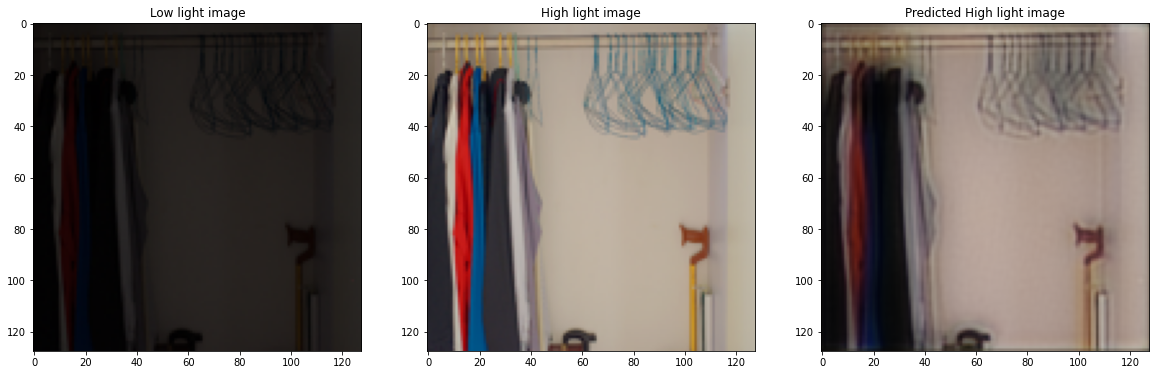

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
plt.imshow(low_img[ : , : , :])
plt.title('Low light image')

plt.subplot(1,3,2)
plt.imshow(high_img[ : , : , :])
plt.title('High light image')

plt.subplot(1,3,3)
plt.imshow(hl_image_final[ : , : , :])
plt.title('Predicted High light image')